# Data analysis : Pfam classification

Good to know : Almost all the details and comment here are discuss in the PDF.

In [28]:
#librairies
import pandas as pd
import os
from sklearn import preprocessing
import matplotlib.pyplot as plt
from Bio import SeqIO
from propythia.protein.sequence import ReadSequence
from propythia.protein.descriptors import ProteinDescritors
import numpy as np

#parameters
dataset_folder = "random_split" #folder containing the dataset 

Proteins are long chains of amino acid residues, which can be classified based on this amino acid sequence. In this notebook, we use a dataset from the Pfam database to perform a quick data analysis.
My goal is to build a protein classifier. 

## Data analysis

In [33]:
def read_data(name_sub_folder):
    """
    read the data from the dataset folder
    input: name_sub_folder: name of the sub folder (train, test or dev)
    output: dataframe containing the data
    """
    full_data = []
    #dataset folder is define as a parameter in the first cell
    for f in os.listdir(os.path.join(dataset_folder, name_sub_folder)):
        data = pd.read_csv(os.path.join(dataset_folder, name_sub_folder, f))
        full_data.append(data)
    return pd.concat(full_data)  

dataset_train = read_data("train")
dataset_test = read_data("test")
dataset_dev = read_data("dev")
#merging the data in one dataframe for analysis purpose (duplicates, distribution...)
df_merge = dataset_train.merge(dataset_dev, how='outer').merge(dataset_test, how='outer')
#same for partitions
partitions = {'Test': dataset_test, 'Dev': dataset_dev, 'Train': dataset_train}
dataset_train.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,GMC_oxred_C,A4WZS5_RHOS5/416-539,PF05199.13,PHPE.SRIRLST.RRDAHGMP.....IP.RIESRLGP............,PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAIL...
1,DUF2887,K9QI92_9NOSO/3-203,PF11103.8,RDSIYYQIFKRFPALIFEL..VD.NRPPQAQNYRFESVEVKETAFR...,RDSIYYQIFKRFPALIFELVDNRPPQAQNYRFESVEVKETAFRIDG...
2,zf-IS66,Q92LC9_RHIME/32-75,PF13005.7,.TCCPDCGG.E..LRLVGED.AS....EILDMI.AAQMKVIEVARL...,TCCPDCGGELRLVGEDASEILDMIAAQMKVIEVARLKKSCRCCE
3,Asp_decarbox,X2GQZ4_9BACI/1-115,PF02261.16,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...
4,Filamin,A7SQM3_NEMVE/342-439,PF00630.19,TACPKQ.CTA....RGLG.............LK.AAPVT.QPT..R...,TACPKQCTARGLGLKAAPVTQPTRFVVILNDCHGQPLGRSEGELEV...


#### Data structure
The Pfam database is a large collection of protein families, each represented by multiple sequence alignments. This database contains 5 features, they are as follows:
- family_id: One word name for family
- sequence_name: Sequence name, in the form "uniprot_accession_id/start_index-end_index".
- family_accession: Accession number in form PFxxxxx.y (Pfam), where xxxxx is the family accession, and y is the version number. Some values of y are greater than ten, and so 'y' has two digits.

The features:
- sequence : These are the amino acid sequence for this domain. There are 20 common amino acids (frequency > 1,000,000), 4 amino acids that are quite uncommon: U, B, O, Z and an unknown labeled as X.
- aligned_sequence: Contains a single sequence from the multiple sequence alignment, with gaps retained. 

In [34]:
#Inspecting the difference between the sequence and the aligned sequence
print(dataset_train.head(1)['sequence'].values[0])
print(dataset_train.head(1)['aligned_sequence'].values[0])

PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAILAAAGCAAPFEEFSSADAFSSTHVFGTCRMGHDPMRNVVDGWGRSHRWPNLFVADASLFPSSGGGESPGLTIQALALRT
PHPE.SRIRLST.RRDAHGMP.....IP.RIESRLGP............DAFARLR....FMAR.TCRAILAAA.........................................................GCAAPFEEFSSADAFSST...........................HVF.GTCRM.GHDPMR......NVVD.GWGRSHRWPNLFVADASLFPSSGGGESPGLTIQALA...LRT


ONLY difference : Spaces are retain in aligned_sequence. For me, this space is a piece of information that could be useful.

### Exploratory data analysis

In [35]:
def get_perc(partition, df_full=df_merge):
    for key, value in partition.items():
        print(key,'is composed of', value.shape[0],'data, which represented',round(value.shape[0]/df_full.shape[0]*100, 2),'% of the total data')


get_perc(partitions)
print('Total data :',df_merge.shape[0])

Test is composed of 126171 data, which represented 9.42 % of the total data
Dev is composed of 126171 data, which represented 9.42 % of the total data
Train is composed of 1086741 data, which represented 81.16 % of the total data
Total data : 1339083


In [30]:
len(df_merge.family_accession.unique())

17929

We have a 17929 labels and 1 339 083 rows in the merge dataset. 
The train dataset represent 80% of our available data, with 10% for test and 10% for dev. The train percentage is a little high but ok, let's check if they have the same labels inside first, and then we will adjust. 

Our task is to predict the family accession based on the AA (Amino Acid) sequences. We will start by examine the family accession columns. 

In [7]:
print('Number of unique classes in Train: ', len(np.unique(dataset_train['family_accession'].values)))
print('Number of unique classes in Val: ', len(np.unique(dataset_dev['family_accession'].values)))
print('Number of unique classes in Test: ', len(np.unique(dataset_test['family_accession'].values)))

Number of unique classes in Train:  17929
Number of unique classes in Val:  13071
Number of unique classes in Test:  13071


In [13]:
dataset_train.family_accession.value_counts()

family_accession
PF13649.6     3637
PF00560.33    1927
PF13508.7     1761
PF06580.13    1537
PF02397.16    1528
              ... 
PF05865.11       1
PF12124.8        1
PF13294.6        1
PF03430.13       1
PF12383.8        1
Name: count, Length: 17929, dtype: int64

In [14]:
dataset_test.family_accession.value_counts()

family_accession
PF13649.6     454
PF00560.33    240
PF13508.7     219
PF06580.13    192
PF02397.16    190
             ... 
PF09462.10      1
PF18646.1       1
PF02995.17      1
PF02896.18      1
PF07400.11      1
Name: count, Length: 13071, dtype: int64

In [15]:
dataset_dev.family_accession.value_counts()

family_accession
PF13649.6     454
PF00560.33    240
PF13508.7     219
PF06580.13    192
PF02397.16    190
             ... 
PF12845.7       1
PF06384.11      1
PF16623.5       1
PF01499.16      1
PF15337.6       1
Name: count, Length: 13071, dtype: int64

1st difficulty

We have more labels in our Train (17929 labels against 13071 for dev and test), it could lead to learn from label without testing them. In order to avoid this useless training over not tested label, we will have to : 
- Clean the train dataset 
- OR split the data between train, test and dev.


2nd difficulty
 
The data are very unbalance, with some class appearing only ones, against hundreds times for the most represented. This is a problem for ML learning, this could lead to learn some class better than others. Moreover, we will not be able to learn a decent representation from class with only one occurrence. We have multiple solution for this : 
- sampling the dataset : sample the top N class with a size M per class. The problem would be more easier and the dataset would be well defined and balanced.
- keeping the full dataset: using a weighted matrix of class representation, allowing us to train on the full dataset and taking in consideration the class distribution. However, some class will have a poor training set, leading to a poor learning (I considered the fact of generating artificial data using bootstrap or data build by adding gaussian noise, but not effective in this case. I also tried to choose a lower and higher bound for our data, but this is not possible here because of the too high inter-quartile distance). 

I chose to sample the dataset, as it will solve both difficulties. 

In [13]:
#print(dataset_train.family_accession.value_counts()[500])
print(dataset_train.family_accession.value_counts()[250])

540


C:\Users\messa\AppData\Local\Temp\ipykernel_18328\894381728.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(dataset_train.family_accession.value_counts()[250])


The label top 250 have 540 occurences. We can sample the top 250 classes, with a number of 500 occurence per class.

<Axes: xlabel='family_accession'>

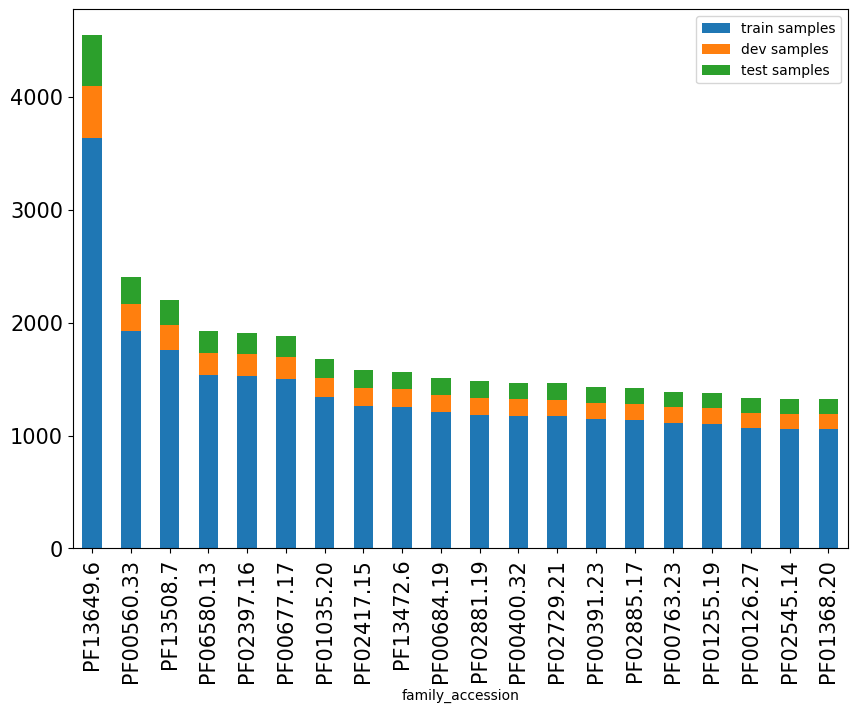

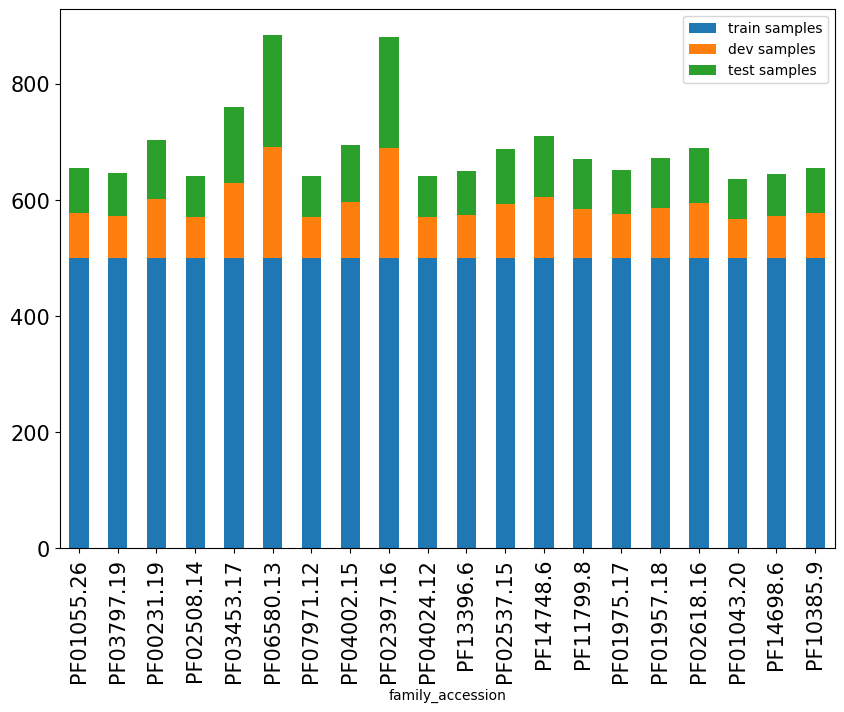

In [50]:
#selecting 250 most common labels
nb_labels = 250
total_sample_size = 500

#get common labels
commonLabels = dataset_train.family_accession.value_counts()[:nb_labels] #-1 as it starts from 0
#build the associated mask
mask = dataset_train.family_accession.isin(commonLabels.index.values)
#update train sample with the mask
train_sample = dataset_train.loc[mask,:]

nrows = len(train_sample)
#train_sm.groupby('family_accession').head()
train_sample = train_sample.groupby('family_accession', group_keys=False).apply(lambda x: x.sample(total_sample_size))
train_sample = train_sample.sample(frac=1).reset_index(drop=True)

#same for dev and test
mask = dataset_dev.family_accession.isin(commonLabels.index.values)
val_sample = dataset_dev.loc[mask,:]
mask = dataset_test.family_accession.isin(commonLabels.index.values)
test_sample = dataset_test.loc[mask,:]

#inspecting the labels distribution before sampling
valCounts = pd.concat([pd.DataFrame(dataset_train.family_accession.value_counts()[:20]), 
           pd.DataFrame(dataset_dev.family_accession.value_counts()[:20]), 
           pd.DataFrame(dataset_test.family_accession.value_counts()[:20])], 
          axis=1)
valCounts.columns = ['train samples', 'dev samples', 'test samples']
valCounts.plot.bar(figsize = (10,7), fontsize = 15, stacked=True)

#inspecting the labels distribution after sampling
mask_val =  val_sample.family_accession.isin(train_sample.family_accession.value_counts()[:20].index.to_list())
mask_test = test_sample.family_accession.isin(train_sample.family_accession.value_counts()[:20].index.to_list())
top20Labels = dataset_train.family_accession.value_counts()[:20].index.to_list()
valCounts = pd.concat([pd.DataFrame(train_sample.family_accession.value_counts()[:20]), 
           pd.DataFrame(val_sample.loc[mask_val,:].family_accession.value_counts()), 
           pd.DataFrame(test_sample.loc[mask_test,:].family_accession.value_counts()[:20])], 
          axis=1)
valCounts.columns = ['train samples', 'dev samples', 'test samples']
valCounts.plot.bar(figsize = (10,7), fontsize = 15, stacked=True)

As it was plan, the train data have 500 occurences per class. We now have a well balanced training dataset (2nd difficulty solved). 

C:\Users\messa\AppData\Local\Temp\ipykernel_18328\2456925085.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_sample['seq_char_count']= val_sample['sequence'].apply(lambda x: len(x))
C:\Users\messa\AppData\Local\Temp\ipykernel_18328\2456925085.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sample['seq_char_count']= test_sample['sequence'].apply(lambda x: len(x))
C:\Users\messa\AppData\Local\Temp\ipykernel_18328\2456925085.py:12: UserWarning: 

`distplot` is a deprecated function and will be

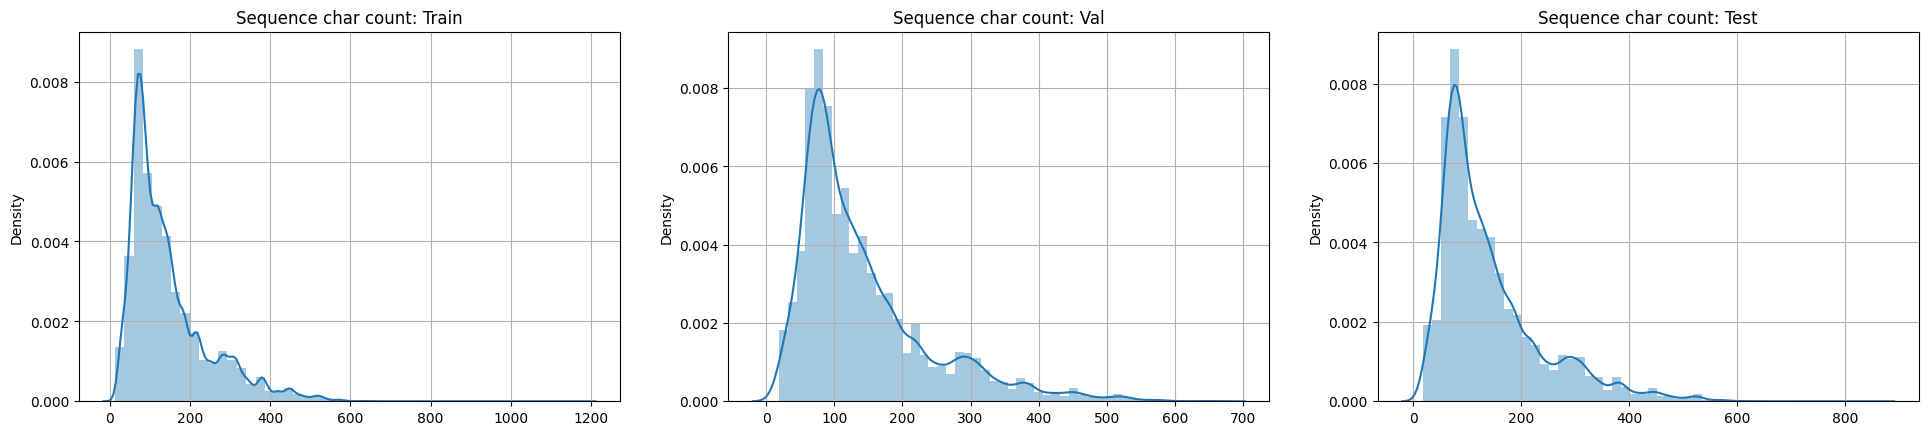

In [51]:
#Inspecting the column sequences
#Checking the length of the sequences


import seaborn as sns

train_sample['seq_char_count']= train_sample['sequence'].apply(lambda x: len(x))
val_sample['seq_char_count']= val_sample['sequence'].apply(lambda x: len(x))
test_sample['seq_char_count']= test_sample['sequence'].apply(lambda x: len(x))

def plot_seq_count(df, data_name):
  sns.distplot(df['seq_char_count'].values)
  plt.title(f'Sequence char count: {data_name}')
  plt.grid(True)

plt.subplot(1, 3, 1)
plot_seq_count(train_sample, 'Train')

plt.subplot(1, 3, 2)
plot_seq_count(val_sample, 'Val')

plt.subplot(1, 3, 3)
plot_seq_count(test_sample, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()



C:\Users\messa\AppData\Local\Temp\ipykernel_18328\1537482689.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_sample['seq_char_count']= val_sample['aligned_sequence'].apply(lambda x: len(x))
C:\Users\messa\AppData\Local\Temp\ipykernel_18328\1537482689.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sample['seq_char_count']= test_sample['aligned_sequence'].apply(lambda x: len(x))
C:\Users\messa\AppData\Local\Temp\ipykernel_18328\1537482689.py:9: UserWarning: 

`distplot` is a deprecated funct

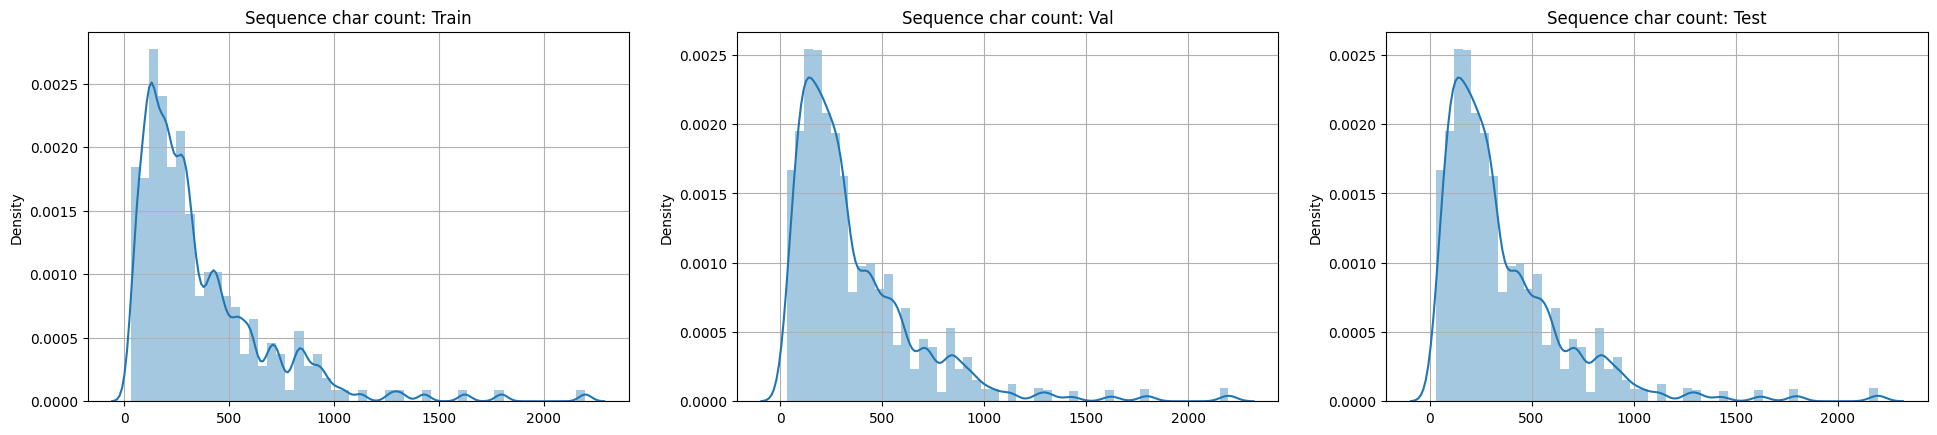

In [18]:
#Inspecting our ALIGNED sequences
#checking the length of the aligned sequences

train_sample['seq_char_count']= train_sample['aligned_sequence'].apply(lambda x: len(x))
val_sample['seq_char_count']= val_sample['aligned_sequence'].apply(lambda x: len(x))
test_sample['seq_char_count']= test_sample['aligned_sequence'].apply(lambda x: len(x))

def plot_seq_count(df, data_name):
  sns.distplot(df['seq_char_count'].values)
  plt.title(f'Sequence char count: {data_name}')
  plt.grid(True)

plt.subplot(1, 3, 1)
plot_seq_count(train_sample, 'Train')

plt.subplot(1, 3, 2)
plot_seq_count(val_sample, 'Val')

plt.subplot(1, 3, 3)
plot_seq_count(test_sample, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

- Most of the (unaligned) AA (Amino Acid) sequences have character counts in the range of 50 to 250.
- Most of the aligned AA sequence have character counts in the range of 100 to 550.

Hence we will use a maximum sequence length of 250 for sequence and 500 for aligned sequence. Sequences less than max_length will be padded and sequences longer will be truncated.

Codes: Train
Total unique codes: 23
Codes: Val
Total unique codes: 22
Codes: Test
Total unique codes: 22


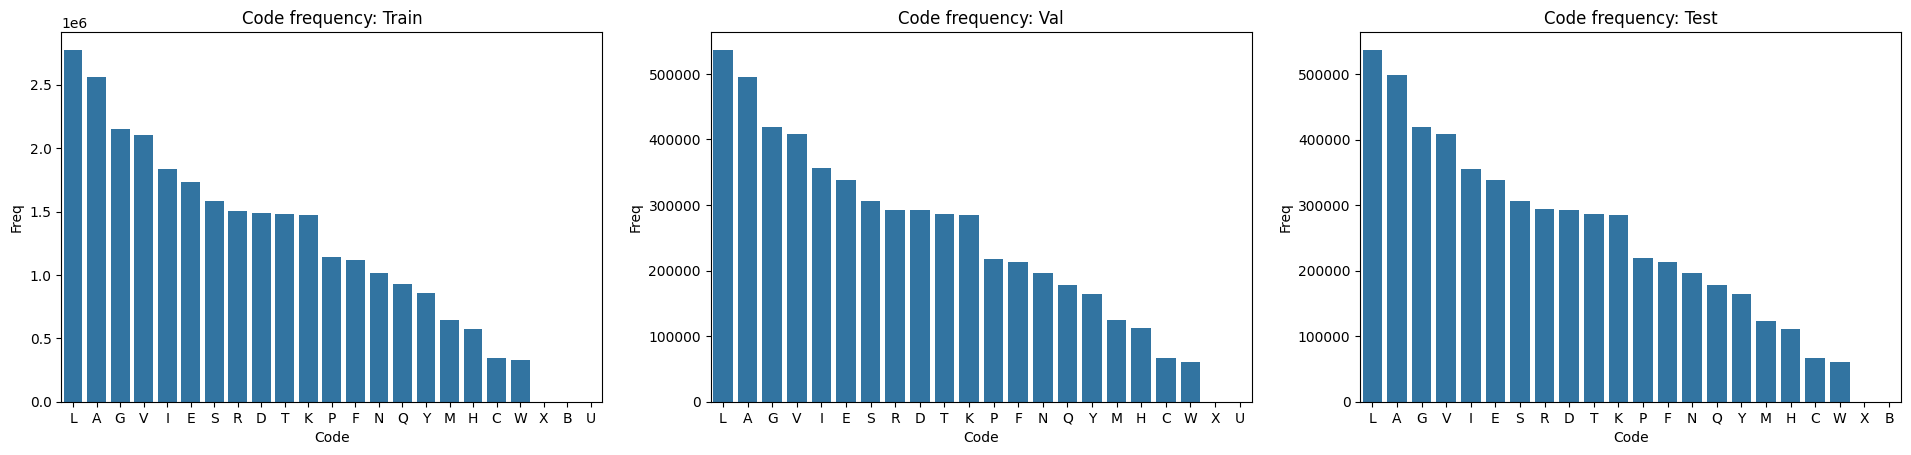

In [75]:
#Inspecting the amino acid codes
from collections import Counter

def get_code_freq(df, data_name):
  
    df = df.apply(lambda x: " ".join(x))
    
#     import pdb; pdb.set_trace()
    codes = []
    for i in df: # concatenation of all codes
        codes.extend(i)
#         print(codes)
    
    codes_dict= Counter(codes)
    codes_dict.pop(' ') # removing white space
  
    print(f'Codes: {data_name}')
    print(f'Total unique codes: {len(codes_dict.keys())}')

    df = pd.DataFrame({'Code': list(codes_dict.keys()), 'Freq': list(codes_dict.values())})
    return df.sort_values('Freq', ascending=False).reset_index()[['Code', 'Freq']]
  
# train code sequence
train_code_freq = get_code_freq(train_sample['sequence'], 'Train')

# val code sequence
val_code_freq = get_code_freq(val_sample['sequence'], 'Val')

# test code sequence
test_code_freq = get_code_freq(test_sample['sequence'], 'Test')

def plot_code_freq(df, data_name):
  
  plt.title(f'Code frequency: {data_name}')
  sns.barplot(x='Code', y='Freq', data=df)

plt.subplot(1, 3, 1)
plot_code_freq(train_code_freq, 'Train')

plt.subplot(1, 3, 2)
plot_code_freq(val_code_freq, 'Val')

plt.subplot(1, 3, 3)
plot_code_freq(test_code_freq, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

As mentionned in the data description, we have 20 common amino acids codes, 4 rares (only 2 here) ones and 1 unknown.

### Label analysis

Let's compare the set of label in train, test and dev :

In [38]:
import itertools
def compare_labels(partitions, label):
    """
    Compare the labels of two partitions

    :param partitions: dictionary of partitions
    :param label: label to compare
    """
    for partition1, partition2 in itertools.combinations(partitions.items(), 2):
        name1, partition1 = partition1
        name2, partition2 = partition2
        print("\n Comparing {} and {}".format(name1, name2))
        if set(partition1[label].unique()) == set(partition2[label].unique()): #first value of the partition is the name (to remove)
            print("{} and {} are the same".format(name1, name2))
            #return None
        elif set(partition1[label].unique()) < set(partition2[label].unique()):
            print("{} is a subset of {}".format(name1, name2))
            #return set(partition2[label].unique()) - set(partition1[label].unique())
        elif set(partition1[label].unique()) > set(partition2[label].unique()):
            print("{} is a subset of {}".format(name1, name2))
        else :
            print("{} and {} are not sharing the same labels".format(name1, name2))
            #return set(partition1[label].unique()) - set(partition2[label].unique())
            
print("Comparing labels of partitions before sampling")
compare_labels(partitions, 'family_id')
print("\nComparing labels of partitions after sampling")
partitions = {'Test': test_sample, 'Dev': val_sample, 'Train': train_sample}
compare_labels(partitions, 'family_id')

Comparing labels of partitions before sampling

 Comparing Test and Dev
Test and Dev are the same

 Comparing Test and Train
Test is a subset of Train

 Comparing Dev and Train
Dev is a subset of Train

Comparing labels of partitions after sampling

 Comparing Test and Dev
Test and Dev are the same

 Comparing Test and Train
Test and Train are the same

 Comparing Dev and Train
Dev and Train are the same


The sampling solved the 2nd difficulty (unbalanced data) and led to solved the 1st difficulty, train,dev and test are sharing the same set of labels.

In [41]:
df_merge.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,GMC_oxred_C,A4WZS5_RHOS5/416-539,PF05199.13,PHPE.SRIRLST.RRDAHGMP.....IP.RIESRLGP............,PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAIL...
1,DUF2887,K9QI92_9NOSO/3-203,PF11103.8,RDSIYYQIFKRFPALIFEL..VD.NRPPQAQNYRFESVEVKETAFR...,RDSIYYQIFKRFPALIFELVDNRPPQAQNYRFESVEVKETAFRIDG...
2,zf-IS66,Q92LC9_RHIME/32-75,PF13005.7,.TCCPDCGG.E..LRLVGED.AS....EILDMI.AAQMKVIEVARL...,TCCPDCGGELRLVGEDASEILDMIAAQMKVIEVARLKKSCRCCE
3,Asp_decarbox,X2GQZ4_9BACI/1-115,PF02261.16,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...
4,Filamin,A7SQM3_NEMVE/342-439,PF00630.19,TACPKQ.CTA....RGLG.............LK.AAPVT.QPT..R...,TACPKQCTARGLGLKAAPVTQPTRFVVILNDCHGQPLGRSEGELEV...


In [44]:
#Checking for duplication in the data
#checking for duplicates in the sequence column
df_merge_sample = train_sample.merge(val_sample, how='outer').merge(test_sample, how='outer')
print('Number of duplicates in the sequence column: {}'.format(df_merge_sample.duplicated(['sequence', "family_accession"]).sum()))
#checking for duplicates in the aligned_sequence column
print('Number of duplicates in the aligned_sequence column: {}'.format(df_merge_sample.duplicated(['aligned_sequence', 'family_accession']).sum()))

#checking for duplicates in the sequence column
print('Number of duplicates in the sequence column: {}'.format(train_sample.duplicated(['sequence', 'family_accession']).sum()))
#checking for duplicates in the aligned_sequence column
print('Number of duplicates in the aligned_sequence column: {}'.format(train_sample.duplicated(['aligned_sequence', 'family_accession']).sum()))

#checking for duplicates in the sequence column
print('Number of duplicates in the sequence column: {}'.format(val_sample.duplicated(['sequence', 'family_accession']).sum()))
#checking for duplicates in the aligned_sequence column
print('Number of duplicates in the aligned_sequence column: {}'.format(val_sample.duplicated(['aligned_sequence', 'family_accession']).sum()))

#checking for duplicates in the sequence column
print('Number of duplicates in the sequence column: {}'.format(test_sample.duplicated(['sequence', 'family_accession']).sum()))
#checking for duplicates in the aligned_sequence column
print('Number of duplicates in the aligned_sequence column: {}'.format(test_sample.duplicated(['aligned_sequence', 'family_accession']).sum()))

Number of duplicates in the sequence column: 139
Number of duplicates in the aligned_sequence column: 136
Number of duplicates in the sequence column: 80
Number of duplicates in the aligned_sequence column: 77
Number of duplicates in the sequence column: 12
Number of duplicates in the aligned_sequence column: 12
Number of duplicates in the sequence column: 5
Number of duplicates in the aligned_sequence column: 5


There is duplicates intra and inter dataset (77 + 12 + 5 < 139)

In [52]:
#dropping duplicates
train_sample.drop_duplicates(['sequence'], inplace=True)
val_sample.drop_duplicates(['sequence'], inplace=True)
test_sample.drop_duplicates(['sequence'], inplace=True)

C:\Users\messa\AppData\Local\Temp\ipykernel_18328\4293111399.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_sample.drop_duplicates(['sequence'], inplace=True)
C:\Users\messa\AppData\Local\Temp\ipykernel_18328\4293111399.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sample.drop_duplicates(['sequence'], inplace=True)


In [54]:
df_merge_sample = train_sample.merge(val_sample, how='outer').merge(test_sample, how='outer')
print('Number of duplicates in the sequence column: {}'.format(df_merge_sample.duplicated(['sequence', "family_accession"]).sum()))

Number of duplicates in the sequence column: 43


There is still 43 duplicates in inter-dataset.

In [81]:
# Find duplicates in df_merge
duplicates = df_merge_sample.duplicated(['sequence', 'family_accession'])
list_duplicates_seq_names = df_merge_sample.sequence_name[duplicates].values

# Find duplicates in datasets
train_sample = train_sample[~train_sample.sequence_name.isin(list_duplicates_seq_names)]
val_sample = val_sample[~val_sample.sequence_name.isin(list_duplicates_seq_names)]
test_sample = test_sample[~test_sample.sequence_name.isin(list_duplicates_seq_names)]

df_merge_sample = train_sample.merge(val_sample, how='outer').merge(test_sample, how='outer')
print('Number of duplicates in the sequence column: {}'.format(df_merge_sample.duplicated(['sequence', "family_accession"]).sum()))


Number of duplicates in the sequence column: 0


The datasets are now cleaned from duplication. 

## Feature extraction

This is a bonus were I show the process for features generation and sequence encoding. Everything is also code in python file for preprocessing. 

### Exctracting properties using propythia
For now we have only AA sequences as input for our training. That's not usable for ML. One of the possibility is to exploit those data by exctracting physical characteristics. Thanks to the library Propythia, we can easily generate them :

In [82]:
def sequence_preprocessing(dataset, column = 'sequence'):
    read_seqs = ReadSequence()
    #preprocessing, cleaning sequences and removing rare amino acid for equivalent with no variation at the codon level
    res = read_seqs.par_preprocessing(dataset= dataset, col = column, B ='N', Z = 'Q', U = 'C', O = 'K', J = 'I', X = '')
    #First step before feature extraction is to create a ProteinDescriptors object
    descriptors = ProteinDescritors(dataset= res ,  col= column)
    return descriptors

descriptors_train = sequence_preprocessing(train_sample)
descriptors_test = sequence_preprocessing(test_sample)
descriptors_dev = sequence_preprocessing(val_sample)

descriptors_train.dataset

,family_id,sequence_name,family_accession,aligned_sequence,sequence,seq_char_count
0,Glyco_hydro_31,G4UY86_NEUT9/239-744,PF01055.26,YFLA..G.P...G..PEEVSKQY.AEVVGLP.AM.MPYWS....LG...,YFLAGPGPEEVSKQYAEVVGLPAMMPYWSLGFHQCKYGWPDLGHVK...,506
1,ANTAR,V5UB15_9BURK/131-184,PF03861.14,AKAES.ELADRKL......ID...RAKRLLMDRRRI..SEQEAYAI...,AKAESELADRKLIDRAKRLLMDRRRISEQEAYAILRKRAMDQGEKL...,54
2,Trigger_N,R7KKX6_9BURK/1-145,PF05697.13,MTEKETTK.S.S.L.ERTLDLTISAQQLQAD....TETILKRRAK....,MTEKETTKSSLERTLDLTISAQQLQADTETILKRRAKTAKAHGFRP...,145
3,DHBP_synthase,J9QXG5_RIEAN/10-202,PF00926.19,PEALEDLRN.GKIIIVV..DD..ENRENE...GDFLSAAELTTPEI...,PEALEDLRNGKIIIVVDDENRENEGDFLSAAELTTPEIINFMTIYG...,193
4,PTS_EIIB,A7MGZ2_CROS8/9-42,PF00367.20,TQILNGVGGEGNILRLENCM.TRVRLEL.....R...DESLMD,TQILNGVGGEGNILRLENCMTRVRLELRDESLMD,34
...,...,...,...,...,...,...
124995,BacA,UPPP2_RHORT/9-260,PF02673.18,AAILGLVEGITEFLPISSTGHL..IIAGSL.L....DFLDE........,AAILGLVEGITEFLPISSTGHLIIAGSLLDFLDEQKRDVFVIVIQL...,252
124996,KH_1,C5LBE4_PERM5/139-210,PF00013.29,QKF.F.EIP..DH.K......VPEVLGPQGIALARIK.E.R.S.GA...,QKFFEIPDHKVPEVLGPQGIALARIKERSGARLEIKAILPTDYHGP...,72
124997,PLDc_N,R4XJ83_TAPDE/43-83,PF13396.6,LVDV.YIFLE.LFK.........SSRPI....ERKILWALLVFF.F...,LVDVYIFLELFKSSRPIERKILWALLVFFFPVIGFLAYFLL,41
124998,TatC,F4CDW3_SPHS2/28-263,PF00902.18,DHLEVLRWHLI.R..SAIAIAIFMGLA.........F..A.F.......,DHLEVLRWHLIRSAIAIAIFMGLAFAFYDFIFDTVIMGPKKPDFWT...,236


In [85]:
def max_min_length(df, column_name):
    """
    Get the maximum and minimum length of strings in the specified column

    :param df: dataframe
    """

    # Get the maximum and minimum length of strings in the specified column
    max_length = df[column_name].str.len().max()
    min_length = df[column_name].str.len().min()
    print(df[column_name].str.len().describe())
    print(f"Maximum length: {max_length}")
    print(f"Minimum length: {min_length}")
    
print('Train')
max_min_length(descriptors_train.dataset, 'sequence')
print('\nDev')
max_min_length(descriptors_dev.dataset, 'sequence')
print('\nTest')
max_min_length(descriptors_test.dataset, 'sequence')

Train
count    124926.000000
mean        146.017082
std          99.102731
min          13.000000
25%          75.000000
50%         117.000000
75%         184.000000
max        1182.000000
Name: sequence, dtype: float64
Maximum length: 1182
Minimum length: 13

Dev
count    22883.000000
mean       142.337718
std         96.065466
min         19.000000
25%         75.000000
50%        113.000000
75%        180.000000
max        664.000000
Name: sequence, dtype: float64
Maximum length: 664
Minimum length: 19

Test
count    22891.000000
mean       142.158010
std         95.774736
min         18.000000
25%         75.000000
50%        113.000000
75%        181.000000
max        853.000000
Name: sequence, dtype: float64
Maximum length: 853
Minimum length: 18


The sequence length seems to vary a lot from 4 to more than 2000 in Train dataset. That's something to take in consideration : 

Using Propythia, one to take into consideration, is that, some of the parameters should not be higher than the sequence length. In datasets were sequences have lengths superior to 40, this is not a porblem. however, if the dataset has some protein sequences with minor lengths that parameters need to be changed. This happens in this dataset, has the minimum length is 4. 

Now we want to generate some feature using propythia. It is not possible to compute all existing feature because of computing power limitation. Let's take the one we can successfully generate in a raisonnable time.

In [84]:
def features_target_split(dataset):
  #return a split between features and target
  return [dataset['sequence'], dataset['family_accession']]

[features_train, target_train] = features_target_split(train_sample)
[features_dev, target_dev] = features_target_split(val_sample)
[features_test, target_test] = features_target_split(test_sample)

In [86]:
#Encode the labels
label_ = preprocessing.LabelEncoder()
label_.fit(target_train)
target = np.arange(len(train_sample['family_accession'].unique()))
dict_classes = dict(zip(label_.classes_, target))
dict_classes

train_sample['class'] = train_sample['family_accession'].map(dict_classes)
test_sample['class'] = test_sample['family_accession'].map(dict_classes)
val_sample['class'] = val_sample['family_accession'].map(dict_classes)
train_sample[['class','family_accession']].head()

,class,family_accession
0,59,PF01055.26
1,176,PF03861.14
2,192,PF05697.13
3,51,PF00926.19
4,19,PF00367.20


##### Using descriptor for feature generation

In [16]:
def get_features(descriptors):
    features_1 = descriptors.get_socn(maxlag = 3, n_jobs= 4)
    features_2 = descriptors.get_adaptable([1,2,3,4,6,7,8,9,10,11,12,14,15,16,18], n_jobs= 4)
    # (starting cleaning) : Remove columns with all values being zero
    features = features_2.merge(features_1[['tausw1', 'tausw2', 'tausw3', 'taugrant1', 'taugrant2',
       'taugrant3']], left_index=True, right_index=True)
    features = features.loc[:, (features != 0).any()]
    
    return features

features_train = get_features(descriptors_train)
features_test = get_features(descriptors_test)
features_dev = get_features(descriptors_dev)

In [17]:
features_train.columns

Index(['family_id', 'sequence_name', 'family_accession', 'aligned_sequence',
       'sequence', 'class', 'length', 'charge', 'chargedensity', 'formulaC',
       'formulaH', 'formulaN', 'formulaO', 'formulaS', 'MW_modlamp', 'Gravy',
       'Aromacity', 'IsoelectricPoint', 'Instability_index', 'SecStruct_helix',
       'SecStruct_turn', 'SecStruct_sheet',
       'Molar_extinction_coefficient_reduced',
       'Molar_extinction_coefficient_oxidized', 'aliphatic_index',
       'bomanindex', 'hydrophobic_ratio', 'A', 'R', 'N', 'D', 'C', 'E', 'Q',
       'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V',
       'tausw1', 'tausw2', 'tausw3', 'taugrant1', 'taugrant2', 'taugrant3'],
      dtype='object')

In [69]:
df_isnull = pd.DataFrame(round((features_train.isnull().sum().sort_values(ascending=False)/features_train.shape[0])*100,1)).reset_index()
df_isnull.columns = ['Columns', '% of Missing Data']
df_isnull.style.format({'% of Missing Data': lambda x:'{:.1%}'.format(abs(x))})
cm = sns.light_palette("skyblue", as_cmap=True)
df_isnull = df_isnull.style.background_gradient(cmap=cm)
df_isnull

,Columns,% of Missing Data
0,family_id,0.000000
1,hydrophobic_ratio,0.000000
2,tausw2,0.000000
3,V,0.000000
4,W,0.000000
5,S,0.000000
6,P,0.000000
7,M,0.000000
8,I,0.000000
9,G,0.000000


The generation worked, we do not have any missing value.

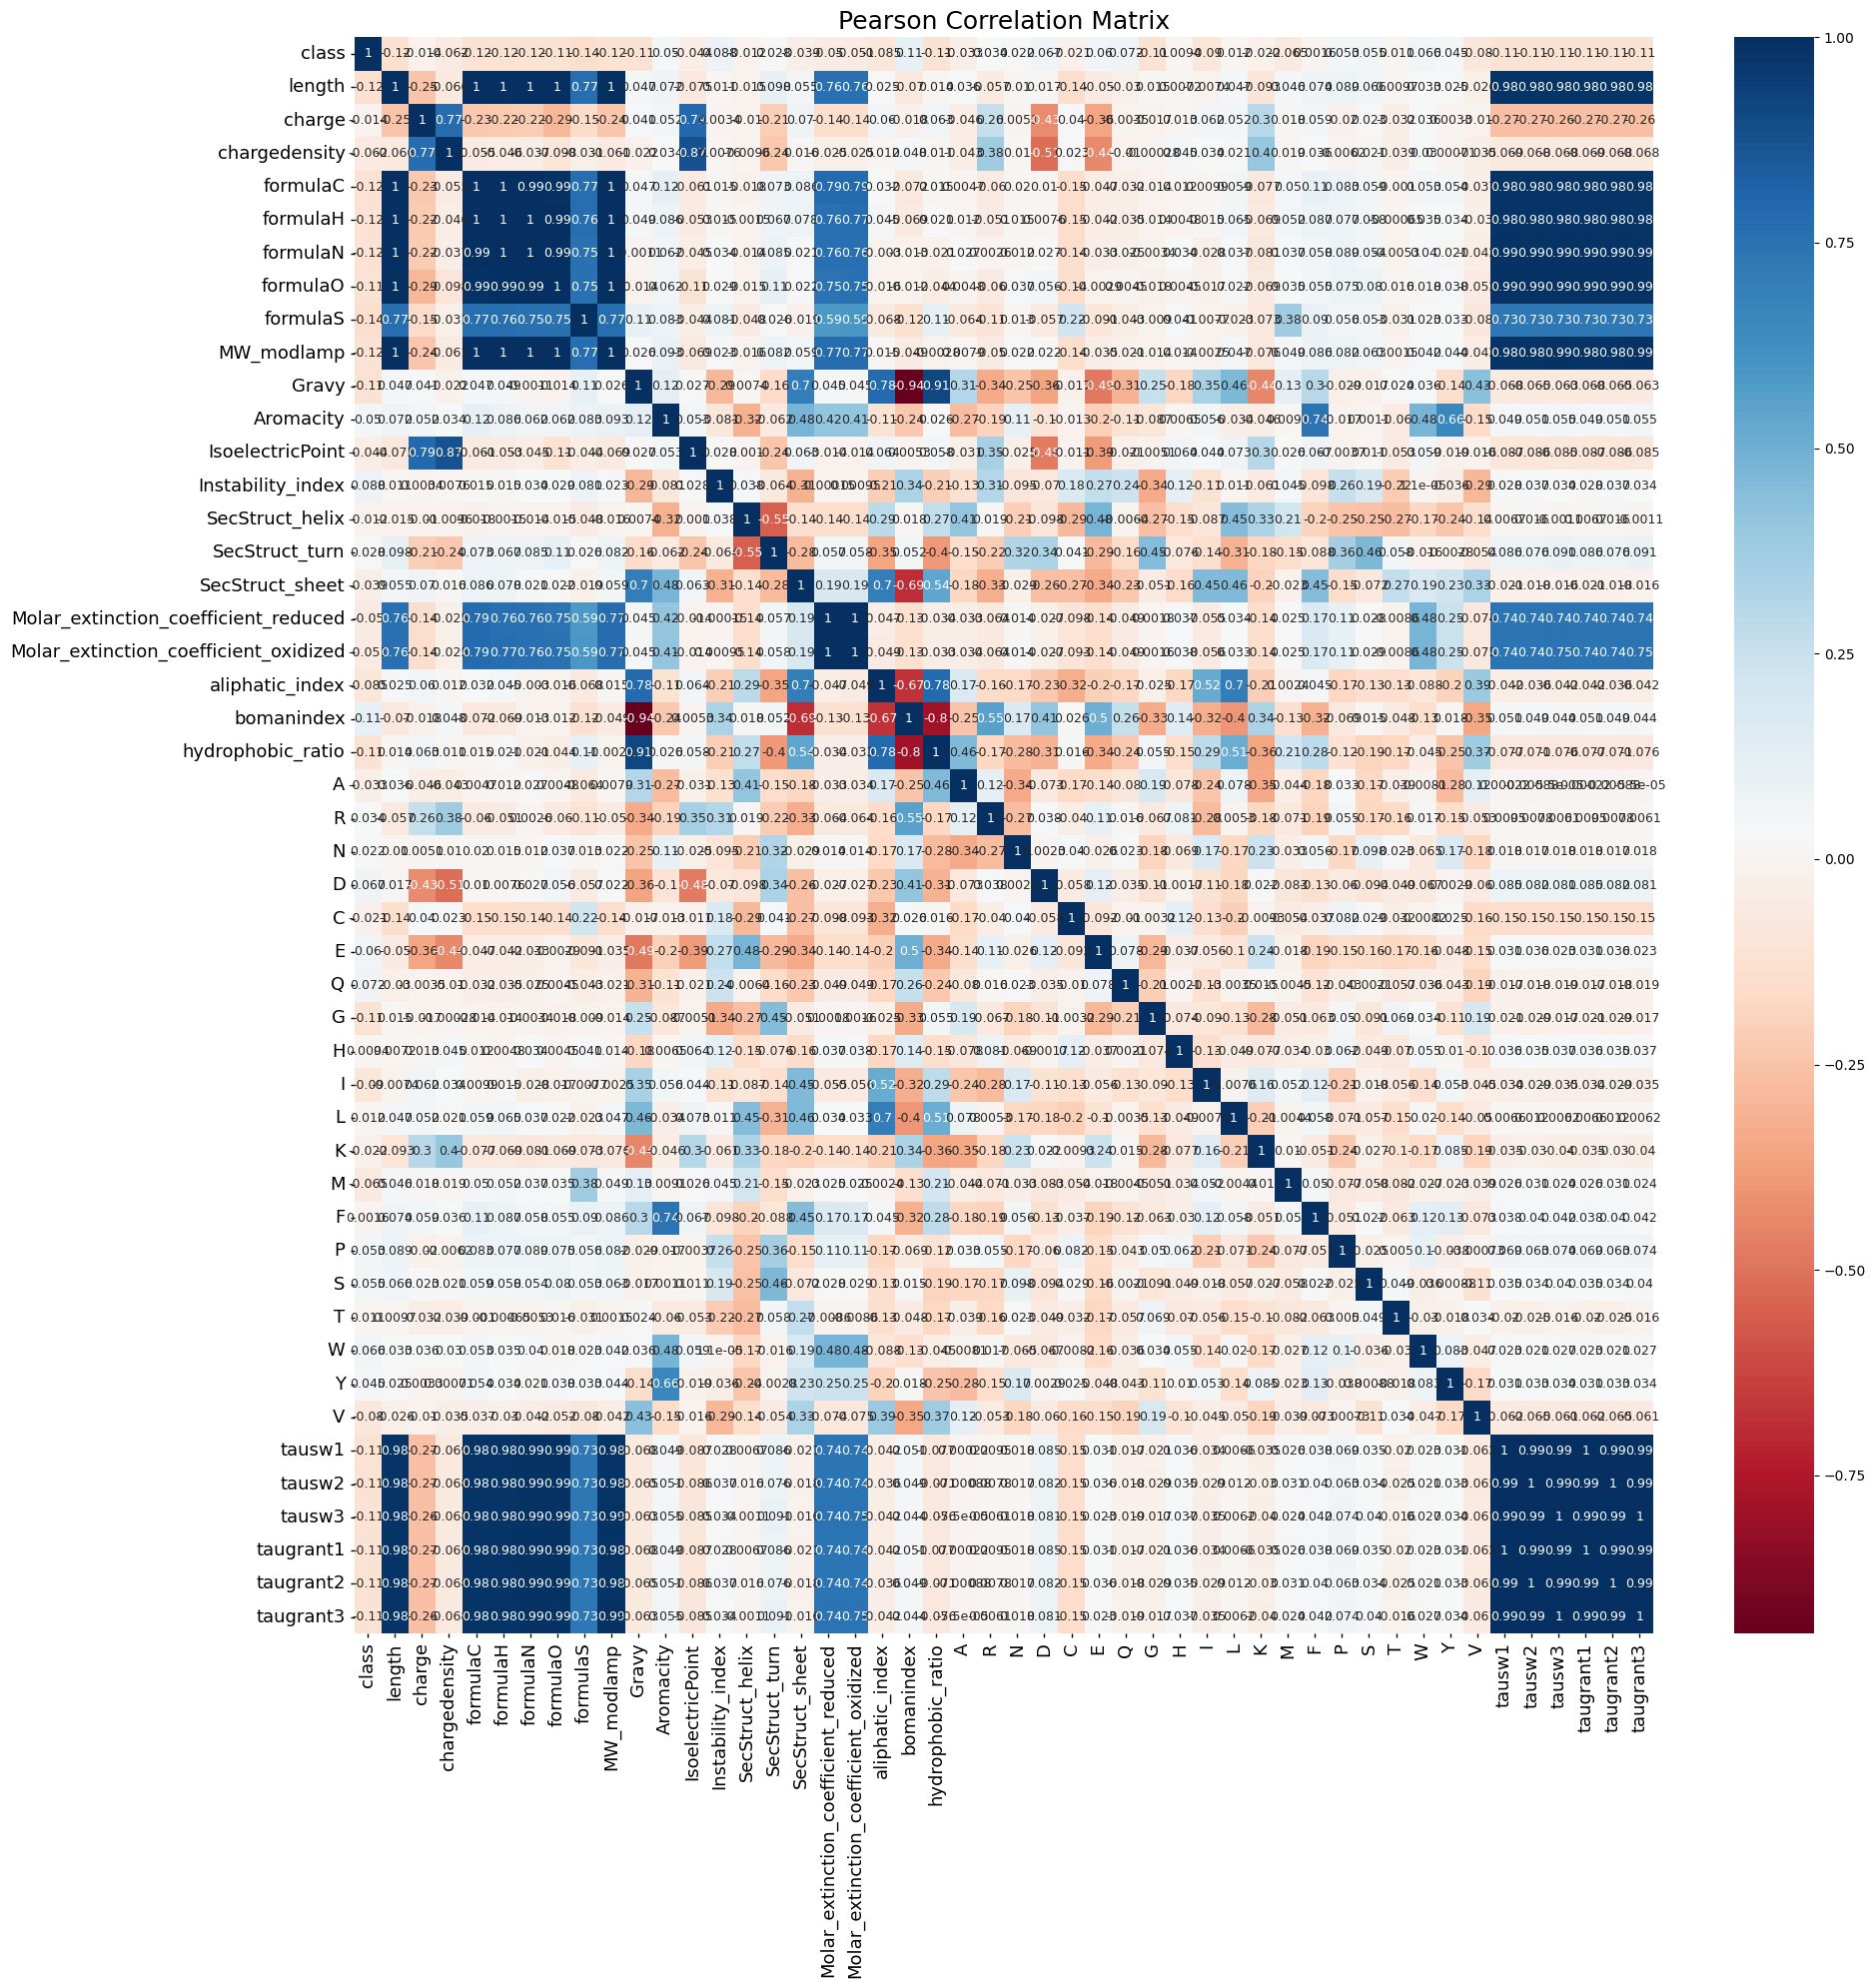

In [20]:
import seaborn as sns

colormap = plt.cm.RdBu
f, ax = plt.subplots(figsize=(20,20))
sns.heatmap(features_train.drop(columns=['family_id','sequence', 'sequence_name', 'family_accession', 'aligned_sequence', 'sequence']).corr(),cmap= colormap,annot=True,ax=ax,annot_kws ={'fontsize':9})
kwargs= {'length':3, 'width':1, 'colors':'black','labelsize':13}
ax.tick_params(**kwargs)
ax.tick_params(**kwargs,axis='x')
plt.title ('Pearson Correlation Matrix', color = 'black',fontsize=18)
plt.tight_layout()
plt.show()

We can see some high correlated features. We can remove feature who are correlated at 0.99 or 1. We can see other correlated data around 0.8, but we can keep them as they could bring more information for classification. We also have poorly correlated data with the label, we could remove feature who have less than 0.05 of correlation. 

<AxesSubplot: >

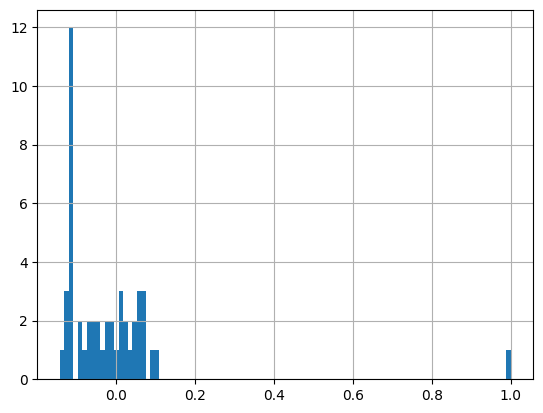

In [23]:
features_train.drop(columns=['family_id','sequence', 'sequence_name', 'family_accession', 'aligned_sequence', 'sequence']).corr()['class'].hist(bins=100)

Globally the data are poorly correlated with label. We will use PCA for features enginerring, to reduce the dimensionality. 

In [36]:
corr = features_train.drop(columns=['family_id','sequence', 'sequence_name', 'family_accession', 'aligned_sequence', 'sequence']).corr()
corr_class = corr['class']
len(corr_class[abs(corr_class)>0.05].index.to_list())

32

32 cfeatures over 48 have a correlation higher than 0.05 with the labels. 

By analyzing the correlation matrix, we can easily see that : 
- length is highly correlated with multiple feature (>0.98)
- Molar_extinction_coefficient_reduced is highly correlated with Molar_extinction_coefficient_oxidized (=1)
- tausw1 is highly correlated is highly correlated with multiple feature (>0.97)
- class is poorly correlated (<0.05) with multiple feature

In [61]:
corr_tausw1 = corr['tausw1']
high_corr_tausw1 = corr_class[abs(corr_tausw1)>0.97].index.to_list()
high_corr_tausw1

['length',
 'formulaC',
 'formulaH',
 'formulaN',
 'formulaO',
 'MW_modlamp',
 'tausw1',
 'tausw2',
 'tausw3',
 'taugrant1',
 'taugrant2',
 'taugrant3']

In [63]:
class_to_keep = corr_class[abs(corr_class)>=0.05].index.to_list()
class_to_keep.remove('class')
print('Number of features to keep :',len(class_to_keep))

corr_len = corr['length']
high_corr_length = corr_class[abs(corr_len)>0.97].index.to_list()
high_corr_length.remove('length')
print('Feature to remove because of high correlation with length :',high_corr_length)

corr_molar = corr['Molar_extinction_coefficient_reduced']
high_corr_molar = corr_class[abs(corr_molar)>0.97].index.to_list()
high_corr_molar.remove('Molar_extinction_coefficient_reduced')
print('Feature to remove because of high correlation with molar :',high_corr_molar)

corr_tausw1 = corr['tausw1']
high_corr_tausw1 = corr_class[abs(corr_tausw1)>0.97].index.to_list()
high_corr_tausw1.remove('tausw1')
high_corr_tausw1.remove('length')
print('Feature to remove because of high correlation with tausw1 :',high_corr_tausw1
      )
class_2_remove = corr_class[abs(corr_class)<0.05].index.to_list()
class_2_remove = class_2_remove + high_corr_length + high_corr_molar + high_corr_tausw1
class_2_remove = list(set(class_2_remove))
print('Number of features to remove :',len(class_2_remove))

Number of features to keep : 31
Feature to remove because of high correlation with length : ['formulaC', 'formulaH', 'formulaN', 'formulaO', 'MW_modlamp', 'tausw1', 'tausw2', 'tausw3', 'taugrant1', 'taugrant2', 'taugrant3']
Feature to remove because of high correlation with molar : ['Molar_extinction_coefficient_oxidized']


In [57]:
features_train = features_train.drop(columns=class_2_remove)
features_test = features_test.drop(columns=class_2_remove)
features_dev = features_dev.drop(columns=class_2_remove)
features_train.columns

Index(['family_id', 'sequence_name', 'family_accession', 'aligned_sequence',
       'sequence', 'class', 'length', 'chargedensity', 'formulaS', 'Gravy',
       'Instability_index', 'Molar_extinction_coefficient_reduced',
       'aliphatic_index', 'bomanindex', 'hydrophobic_ratio', 'D', 'E', 'Q',
       'G', 'I', 'M', 'P', 'S', 'W', 'V', 'tausw2', 'taugrant2'],
      dtype='object')

In [66]:
print('Number of features to remove :',len(features_train.columns))


Number of features to remove : 27


### Feature transformation for deep

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

def features_target_split(dataset):
  #return a split between features and target
  return [dataset['sequence'], dataset['family_accession']]

[features, target] = features_target_split(train_sample)
[features_dev, target_dev] = features_target_split(val_sample)
[features_test, target_test] = features_target_split(test_sample)

In [8]:
def cut_protein_sequence(sequence):
    return sequence.apply(lambda seq: list(seq))

features = cut_protein_sequence(features)
features_dev = cut_protein_sequence(features_dev)
features_test = cut_protein_sequence(features_test)
features

0        [P, H, P, E, S, R, I, R, L, S, T, R, R, D, A, ...
1        [R, D, S, I, Y, Y, Q, I, F, K, R, F, P, A, L, ...
2        [T, C, C, P, D, C, G, G, E, L, R, L, V, G, E, ...
3        [M, L, R, M, M, M, N, S, K, I, H, R, A, T, V, ...
4        [T, A, C, P, K, Q, C, T, A, R, G, L, G, L, K, ...
                               ...                        
13510    [V, E, E, P, S, M, E, A, F, L, H, A, L, L, P, ...
13511    [A, A, T, Q, V, I, S, S, L, S, S, A, Q, K, Y, ...
13512    [A, Y, E, I, L, Y, I, I, R, P, D, M, D, E, E, ...
13513    [L, D, Y, V, P, A, L, V, A, D, L, L, A, V, L, ...
13514    [T, P, L, E, I, A, E, E, L, T, L, P, P, T, L, ...
Name: sequence, Length: 1086741, dtype: object

In [9]:
tokenizer_seq=  Tokenizer(num_words = 2000) 
tokenizer_seq.fit_on_texts(features)

In [10]:
features = tokenizer_seq.texts_to_sequences(features)
features_dev = tokenizer_seq.texts_to_sequences(features_dev)
features_test = tokenizer_seq.texts_to_sequences(features_test)

In [11]:
 features = pad_sequences(features, maxlen = 200, padding = "post", truncating = "post")
features.shape

(1086741, 200)

In [12]:
features_dev = pad_sequences(features_dev, maxlen = features.shape[1], padding = "post", truncating = "post")
features_test = pad_sequences(features_test, maxlen = features.shape[1], padding = "post", truncating = "post")

In [13]:
print(tokenizer_seq.word_index)
vocabulary = len(tokenizer_seq.word_index)

{'l': 1, 'a': 2, 'v': 3, 'g': 4, 'e': 5, 's': 6, 'i': 7, 'r': 8, 'd': 9, 'k': 10, 't': 11, 'p': 12, 'f': 13, 'n': 14, 'q': 15, 'y': 16, 'm': 17, 'h': 18, 'c': 19, 'w': 20, 'x': 21, 'u': 22, 'b': 23, 'o': 24, 'z': 25}
